# Consistency Analysis

In [7]:
# Imports
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, cohen_kappa_score, mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

# Import all 10 iterations (of 50 reports each), and the combine them
df_reports_it1 = pd.read_csv('../data_audit/op_graded_iteration_1.csv')
df_reports_it2 = pd.read_csv('../data_audit/op_graded_iteration_2.csv')
df_reports_it3 = pd.read_csv('../data_audit/op_graded_iteration_3.csv')
df_reports_it4 = pd.read_csv('../data_audit/op_graded_iteration_4.csv')
df_reports_it5 = pd.read_csv('../data_audit/op_graded_iteration_5.csv')
df_reports_it6 = pd.read_csv('../data_audit/op_graded_iteration_6.csv')
df_reports_it7 = pd.read_csv('../data_audit/op_graded_iteration_7.csv')
df_reports_it8 = pd.read_csv('../data_audit/op_graded_iteration_8.csv')
df_reports_it9 = pd.read_csv('../data_audit/op_graded_iteration_9.csv')
df_reports_it10 = pd.read_csv('../data_audit/op_graded_iteration_10.csv')

# Combine all iterations into a single DataFrame
# Set REPORT as index for each dataframe
df_reports_it1_indexed = df_reports_it1.set_index('REPORT')
df_reports_it2_indexed = df_reports_it2.set_index('REPORT')
df_reports_it3_indexed = df_reports_it3.set_index('REPORT')
df_reports_it4_indexed = df_reports_it4.set_index('REPORT')
df_reports_it5_indexed = df_reports_it5.set_index('REPORT')
df_reports_it6_indexed = df_reports_it6.set_index('REPORT')
df_reports_it7_indexed = df_reports_it7.set_index('REPORT')
df_reports_it8_indexed = df_reports_it8.set_index('REPORT')
df_reports_it9_indexed = df_reports_it9.set_index('REPORT')
df_reports_it10_indexed = df_reports_it10.set_index('REPORT')

# Combine all iterations using the REPORT index
df_reports_combined = pd.concat([
    df_reports_it1_indexed, df_reports_it2_indexed, df_reports_it3_indexed, 
    df_reports_it4_indexed, df_reports_it5_indexed, df_reports_it6_indexed,
    df_reports_it7_indexed, df_reports_it8_indexed, df_reports_it9_indexed, 
    df_reports_it10_indexed
], axis=1)

# Reset index to make REPORT a column again
df_reports_combined = df_reports_combined.reset_index()

In [11]:
# We use the paired Wilcoxon Signed-Rank Test to compare the difference between each iteration

from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests

def pairwise_wilcoxon_analysis(df, grade_type='priority_hybrid', iterations=10):
    """
    Perform pairwise Wilcoxon signed-rank tests between all iteration pairs.
    """
    iteration_cols = [f"{grade_type}_{i+1}" for i in range(iterations) 
                     if f"{grade_type}_{i+1}" in df.columns]
    
    if len(iteration_cols) < 2:
        print("Need at least 2 iterations for comparison")
        return None
    
    # Perform all pairwise comparisons
    p_values = []
    comparisons = []
    
    for i, col1 in enumerate(iteration_cols):
        for j, col2 in enumerate(iteration_cols):
            if i < j:  # Only compare each pair once
                # Remove NaN pairs
                data1 = df[col1].dropna()
                data2 = df[col2].dropna()
                
                # Find common indices
                common_idx = data1.index.intersection(data2.index)
                
                if len(common_idx) > 5:  # Need sufficient data
                    stat, p_val = wilcoxon(data1[common_idx], data2[common_idx])
                    p_values.append(p_val)
                    comparisons.append(f"{col1} vs {col2}")
                else:
                    print(f"Insufficient data for {col1} vs {col2}")
    
    # Multiple testing correction
    if p_values:
        rejected, p_corrected, _, _ = multipletests(p_values, method='bonferroni')
        
        results_df = pd.DataFrame({
            'Comparison': comparisons,
            'Raw_p_value': p_values,
            'Corrected_p_value': p_corrected,
            'Significant': rejected
        })

        sig_differences_txt = f"{sum(rejected)}/{len(rejected)}"
        
        return results_df, sig_differences_txt
    
    return None

# Example usage:
wilcoxon_results_hybrid, sig_differences_txt_hybrid = pairwise_wilcoxon_analysis(df_reports_combined, 'priority_hybrid', 10)
wilcoxon_results_algo, sig_differences_txt_algo = pairwise_wilcoxon_analysis(df_reports_combined, 'priority_algo', 10)
wilcoxon_results_llm, sig_differences_txt_llm = pairwise_wilcoxon_analysis(df_reports_combined, 'priority_llm', 10)
wilcoxon_results_judge, sig_differences_txt_judge = pairwise_wilcoxon_analysis(df_reports_combined, 'judge_grade', 10)

print("=== PAIRWISE WILCOXON TESTS ===")
print("Significant differences (after Bonferroni correction): ")
print("")
print(f"- Semialgo method: {sig_differences_txt_hybrid}")
print(f"- LLM method: {sig_differences_txt_llm}")
print(f"- Hybrid method: {sig_differences_txt_hybrid}")
print(f"- Judge method: {sig_differences_txt_judge}")
print("")
#display(wilcoxon_results.round(4))

=== PAIRWISE WILCOXON TESTS ===
Significant differences (after Bonferroni correction): 

- Semialgo method: 0/45
- LLM method: 0/45
- Hybrid method: 0/45
- Judge method: 0/45



c:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_wilcoxon.py:172: RuntimeWarning: invalid value encountered in scalar divide
  z = (r_plus - mn) / se


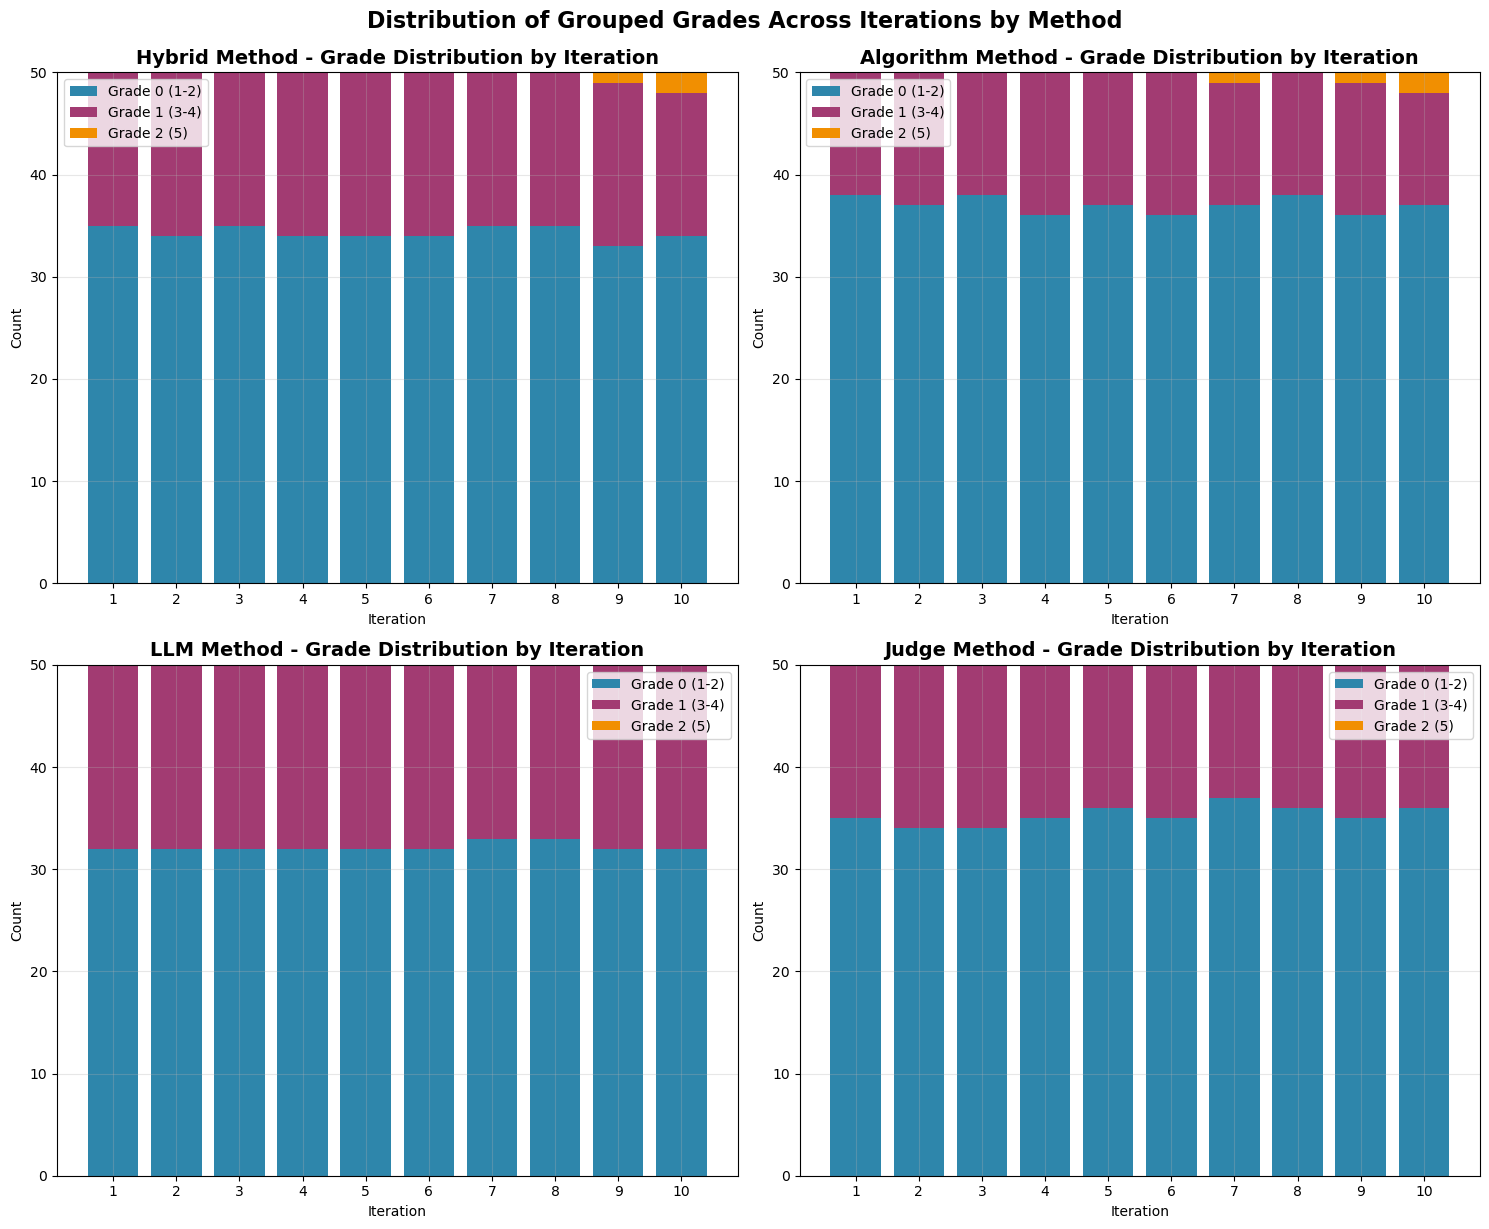

In [13]:
# Group grades into binary categories
def group_grades(grade):
    if grade in [1, 2]:
        return 0
    elif grade in [3, 4]:
        return 1
    elif grade == 5:
        return 2
    else:
        return grade

# Create grouped data for each method
methods_data = {
    'Hybrid': [f'priority_hybrid_{i}' for i in range(1, 11)],
    'Algorithm': [f'priority_algo_{i}' for i in range(1, 11)],
    'LLM': [f'priority_llm_{i}' for i in range(1, 11)],
    'Judge': [f'judge_grade_{i}' for i in range(1, 11)]
}

# Create subplot figure
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

# Colors for the three grouped grades
colors = ['#2E86AB', '#A23B72', '#F18F01']
grade_labels = ['Grade 0 (1-2)', 'Grade 1 (3-4)', 'Grade 2 (5)']

for idx, (method_name, columns) in enumerate(methods_data.items()):
    ax = axes[idx]
    
    # Prepare data for stacked bar chart
    iterations = list(range(1, 11))
    grade_counts = {0: [], 1: [], 2: []}
    
    for col in columns:
        if col in df_reports_combined.columns:
            # Group grades and count occurrences
            grouped_data = df_reports_combined[col].apply(group_grades)
            counts = grouped_data.value_counts().sort_index()
            
            # Fill in missing grades with 0
            for grade in [0, 1, 2]:
                grade_counts[grade].append(counts.get(grade, 0))
    
    # Create stacked bar chart
    bottom_0 = [0] * len(iterations)
    bottom_1 = grade_counts[0]
    
    ax.bar(iterations, grade_counts[0], label=grade_labels[0], color=colors[0])
    ax.bar(iterations, grade_counts[1], bottom=bottom_1, label=grade_labels[1], color=colors[1])
    ax.bar(iterations, grade_counts[2], bottom=[b1 + g1 for b1, g1 in zip(bottom_1, grade_counts[1])], 
           label=grade_labels[2], color=colors[2])
    
    ax.set_title(f'{method_name} Method - Grade Distribution by Iteration', fontsize=14, fontweight='bold')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Count')
    ax.set_xticks(iterations)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Distribution of Grouped Grades Across Iterations by Method', 
             fontsize=16, fontweight='bold', y=1.02)
plt.show()